In [1]:
from broyden import *
from solver_helper import *

import matplotlib.pyplot as plt 
import pandas as pd
import time

In [2]:
from scipy import optimize

In [3]:
#rmf = eos(g_sigma_N = 8.79509376389, g_omega_N = 9.1815177, g_rho_N = 9.7793745, b = 0.00414, c = 0.00716)
rmf = eos(g_sigma_N = 8.784820, g_omega_N = 8.720086, g_rho_N = 8.544795, b = 0.008628, c = -0.002433)
baryon_list = [Neutron, Proton]
meson_list = [sigma, omega, rho]
lepton_list = [electron]

In [4]:
B = full_solve(rmf, baryon_list, lepton_list, meson_list, [7.90, 4.50, -2.2, 210.0, 43.0, 43.0])
B

,nB/n0,sigma field (MeV),rho field (MeV),omega field (MeV),Neutron kF (MeV),Proton kF (MeV),electron kF (MeV),Neutron frac,Proton frac,electron frac
0,0.27,7.941193,-2.247962,4.514730,210.426938,43.238314,43.238314,0.991399,0.008601,0.008601
1,0.28,8.199099,-2.329050,4.681942,212.960614,44.528049,44.528049,0.990942,0.009058,0.009058
2,0.29,8.455030,-2.409949,4.849154,215.432600,45.809033,45.809033,0.990477,0.009523,0.009523
3,0.30,8.709030,-2.490655,5.016367,217.846350,47.081534,47.081534,0.990006,0.009994,0.009994
4,0.31,8.961139,-2.571167,5.183579,220.205018,48.345801,48.345801,0.989528,0.010472,0.010472
...,...,...,...,...,...,...,...,...,...,...
768,7.95,75.202688,-31.660986,132.933718,588.110921,418.542097,418.542097,0.735053,0.264947,0.264947
769,7.96,75.229647,-31.685294,133.100930,588.326705,418.778116,418.778116,0.734938,0.265062,0.265062
770,7.97,75.256548,-31.709590,133.268142,588.542307,419.013916,419.013916,0.734823,0.265177,0.265177
771,7.98,75.283392,-31.733873,133.435355,588.757728,419.249498,419.249498,0.734709,0.265291,0.265291


In [5]:
nb_array = B.loc[:,'nB/n0'].values

sigma_array = B.loc[:,'sigma field (MeV)'].values
rho_array = B.loc[:,'rho field (MeV)'].values
omega_array = B.loc[:,'omega field (MeV)'].values


neutron_frac = B.loc[:, 'Neutron frac'].values
proton_frac = B.loc[:, 'Proton frac'].values
electron_frac = B.loc[:, 'electron frac'].values

fermi_n = B.loc[:, 'Neutron kF (MeV)'].values
fermi_p = B.loc[:, 'Proton kF (MeV)'].values
fermi_e = B.loc[:, 'electron kF (MeV)'].values

In [7]:
def mass_eff(Baryon, sigma_field):
    return Baryon.num_mass - Baryon.num_g_sigma * sigma_field 

def eff_energy(Baryon, fermi, sigma_field):
    m = mass_eff(Baryon, sigma_field)
    return np.sqrt(fermi**2 + m**2) 

def log_factor(Baryon, fermi, sigma_field):
    m = mass_eff(Baryon, sigma_field) 
    EF = eff_energy(Baryon, fermi, sigma_field) 
    
    return np.log((EF + fermi)/m)

## Checking Sigma Partial Derivative 
$$
    m_\sigma^2 \sigma + 
    \frac{\partial U}{\partial \sigma} = \sum_i g_{\sigma i }n^s_i 
$$
Idea:
1. So we know that $k_{F_n}, k_{F_p}$ appear in ''pairs'' due to other constraints on the system like Baryon number conservation. 
2. Solve for $\sigma(k_{F_n}, k_{F_p})$ while fixing $k_{F_p}$ but for a few points around the correspondin $k_{F_n}$ value. Then take the derivative and should give us the value for
$$
    \frac{\partial \sigma}{\partial k_{F_n}}\bigg|_{k_{F_n}}
$$

In [8]:
def d_U(sigma_field):
    term1 = sigma.num_b * Neutron.num_mass * Neutron.num_g_sigma**3 * sigma_field**2 
    term2 = sigma.num_c * Neutron.num_g_sigma**4 * sigma_field**3 
    
    return term1 + term2 

In [9]:
def scalar_dens(fermi, sigma_field, Baryon):
    m = Baryon.num_mass - Baryon.num_g_sigma * sigma_field 
    EF = np.sqrt(fermi**2 + m**2) 
    log_fac = np.log((EF + fermi)/m)
    
    term1 = EF * fermi 
    term2 = -m**2 * log_fac 
    
    return m/(2*np.pi**2)*(term1 + term2)

In [10]:
def sigma_eomm(sigma_field, k_n, k_p):
    term1 = sigma.num_mass**2 * sigma_field
    term2 = d_U(sigma_field) 
    term3 = - Neutron.num_g_sigma * scalar_dens(k_n, sigma_field, Neutron)
    term4 = - Proton.num_g_sigma * scalar_dens(k_p, sigma_field, Proton)
    
    return term1 + term2 + term3 + term4

In [14]:
optimize.fsolve(sigma_eomm, x0 = 10.0, args = (210, 72), xtol=1.0e-10)

array([8.1217947])

In [11]:
def five_point_derivative(func, init_guess, k_n, k_p, h, name):
    # calculates derivative
    
    numerator = 0
    denominator = 12*h
    
    if (name == "Neutron"):
        numerator += func(init_guess, k_n - 2*h, k_p)
        numerator -= 8 * func(init_guess, k_n - h, k_p)
        numerator += 8 * func(init_guess, k_n + h, k_p) 
        numerator -= func(init_guess, k_n + 2*h, k_p) 
        
        return numerator/denominator 
    
    elif (name == "Proton"):
        numerator += func(init_guess, k_n, k_p - 2*h) 
        numerator -= 8 * func(init_guess, k_n, k_p - h)
        numerator += 8 * func(init_guess, k_n, k_p + h) 
        numerator -= func(init_guess, k_n, k_p + 2*h)
    
        return numerator/denominator 

In [12]:
def func(init_guess, k_n, k_p):
    return optimize.fsolve(sigma_eomm, x0 = init_guess, args = (k_n, k_p))

In [67]:
def test(x,y,z):
    return x**2 + y**2 + z**2 - 8 

In [68]:
def func2(init_guess, y, z):
    return optimize.fsolve(test, x0 = init_guess, args = (y,z))

In [72]:
five_point_derivative(func2, 0.5, 0.5, 1.5, 0.1, "Neutron")

array([-0.21319948])

In [73]:
five_point_derivative(func2, 0.5, 0.5, 1.5, 0.1, "Proton")

array([-0.63959326])

In [17]:
partial_sigma_kfn = np.zeros(len(nb_array)) 
partial_sigma_kfp = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_sigma_kfn[i] = five_point_derivative(func, sigma_array[i], fermi_n[i], fermi_p[i], 0.01, "Neutron")

for i in range(len(nb_array)):
    partial_sigma_kfp[i] = five_point_derivative(func, sigma_array[i], fermi_n[i], fermi_p[i], 0.01, "Proton")

In [120]:
partial_sigma_kfn

array([0.09874822, 0.10035537, 0.10191288, 0.10342327, 0.10488883,
       0.10631171, 0.1076939 , 0.10903723, 0.11034344, 0.11161412,
       0.11285077, 0.11405481, 0.11522755, 0.11637022, 0.11748399,
       0.11856996, 0.11962916, 0.12066257, 0.12167111, 0.12265565,
       0.12361701, 0.12455599, 0.12547332, 0.1263697 , 0.12724583,
       0.12810232, 0.12893979, 0.12975882, 0.13055996, 0.13134374,
       0.13211067, 0.13286122, 0.13359586, 0.13431503, 0.13501916,
       0.13570864, 0.13638387, 0.13704522, 0.13769305, 0.1383277 ,
       0.1389495 , 0.13955877, 0.14015583, 0.14074095, 0.14131443,
       0.14187653, 0.14242754, 0.14296768, 0.14349722, 0.14401639,
       0.14452542, 0.14502452, 0.14551392, 0.14599381, 0.1464644 ,
       0.14692589, 0.14737845, 0.14782227, 0.14825752, 0.14868438,
       0.14910301, 0.14951357, 0.14991621, 0.15031108, 0.15069833,
       0.1510781 , 0.15145053, 0.15181575, 0.15217389, 0.15252508,
       0.15286944, 0.15320708, 0.15353813, 0.1538627 , 0.15418

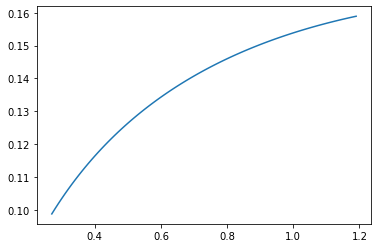

In [121]:
plt.plot(nb_array, partial_sigma_kfn)

In [122]:
partial_sigma_kfp

array([0.00428444, 0.0045119 , 0.00474216, 0.0049751 , 0.00521061,
       0.00544858, 0.0056889 , 0.00593147, 0.0061762 , 0.00642299,
       0.00667175, 0.00692241, 0.00717487, 0.00742906, 0.00768489,
       0.0079423 , 0.00820122, 0.00846156, 0.00872328, 0.00898629,
       0.00925055, 0.00951598, 0.00978253, 0.01005015, 0.01031877,
       0.01058834, 0.01085881, 0.01113013, 0.01140225, 0.01167512,
       0.0119487 , 0.01222294, 0.01249779, 0.01277321, 0.01304917,
       0.01332561, 0.01360251, 0.01387982, 0.0141575 , 0.01443552,
       0.01471385, 0.01499244, 0.01527127, 0.0155503 , 0.0158295 ,
       0.01610884, 0.01638828, 0.01666781, 0.01694738, 0.01722698,
       0.01750657, 0.01778612, 0.01806562, 0.01834503, 0.01862434,
       0.01890351, 0.01918252, 0.01946135, 0.01973998, 0.02001839,
       0.02029655, 0.02057444, 0.02085204, 0.02112934, 0.0214063 ,
       0.02168293, 0.02195918, 0.02223506, 0.02251053, 0.02278559,
       0.02306021, 0.02333438, 0.02360809, 0.02388131, 0.02415

In [22]:
partial_sigma_nb = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    partial_sigma_nb[i] = partial_sigma_kfn[i]*np.pi**2 * neutron_frac[i]/fermi_n[i]**2

In [23]:
def partial_E_partial_kf(Baryon, fermi, sigma_field, partial_sigma):
    m = mass_eff(Baryon, sigma_field)
    EF = eff_energy(Baryon, fermi, sigma_field)
    
    term1 = fermi/EF 
    term2 = -m/EF * Baryon.num_g_sigma * partial_sigma
    
    return term1 + term2 

In [24]:
def partial_fermi(fermi, nb, baryon_frac, ind_var_name):
    if (ind_var_name == 'nb'):
        return np.pi**2 * baryon_frac / fermi**2
    elif (ind_var_name == 'frac'):
        return np.pi**2 * nb / fermi**2 

In [25]:
def partial_chem_pot(Baryon, fermi, sigma_field, partial_sigma, nb, baryon_frac, ind_var_name):
    part_E = partial_E_partial_kf(Baryon, fermi, sigma_field, partial_sigma)
    part_kf = partial_fermi(fermi, nb, baryon_frac, ind_var_name)
    
    return part_E * part_kf

In [26]:
partial_proton_nb = np.zeros(len(nb_array))
partial_neutron_nb = np.zeros(len(nb_array))

partial_proton_xe = np.zeros(len(nb_array))
partial_neutron_xe = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_proton_nb[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp[i], nb_array[i],\
                                        proton_frac[i], 'nb')
    partial_proton_xe[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp[i], nb_array[i],\
                                        proton_frac[i], 'frac')
    
    partial_neutron_nb[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn[i], nb_array[i],\
                                        neutron_frac[i], 'nb')
    partial_neutron_xe[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn[i], nb_array[i],\
                                        neutron_frac[i], 'frac')

In [27]:
part_mu_tilde_part_nb = partial_neutron_nb - partial_proton_nb 
part_mu_tilde_part_xe = partial_neutron_xe - partial_proton_xe

In [28]:
neutron_chem_pot = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    neutron_chem_pot[i] = eff_energy(Neutron, fermi_n[i], sigma_array[i])

In [29]:
sound_speed_diff = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    sound_speed_diff[i] = -(nb_array[i]*n0*hc**3)**2/neutron_chem_pot[i] * part_mu_tilde_part_nb[i]**2 / part_mu_tilde_part_xe[i]

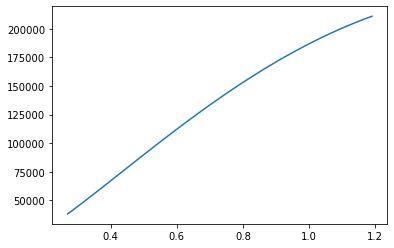

In [50]:
plt.plot(nb_array, sound_speed_diff)

In [30]:
eff_energy_array = np.zeros(len(nb_array))

for i in range(len(eff_energy_array)):
    eff_energy_array[i] = eff_energy(Proton, fermi_p[i], sigma_array[i])

In [52]:
eff_energy_array

array([870.31278145, 868.11512446, 865.93660458, 863.77682341,
       861.63539744, 859.51195729, 857.40614696, 855.31762309,
       853.24605438, 851.19112092, 849.15251368, 847.12993394,
       845.12309283, 843.13171085, 841.15551745, 839.1942506 ,
       837.24765643, 835.31548887, 833.39750929, 831.49348619,
       829.60319491, 827.72641733, 825.86294161, 824.01256193,
       822.17507825, 820.35029607, 818.53802625, 816.73808476,
       814.95029249, 813.17447512, 811.41046285, 809.65809033,
       807.91719642, 806.18762409, 804.46922025, 802.76183562,
       801.0653246 , 799.37954513, 797.70435859, 796.03962967,
       794.38522628, 792.74101939, 791.10688303, 789.48269407,
       787.86833223, 786.26367995, 784.66862229, 783.08304687,
       781.5068438 , 779.93990558, 778.38212705, 776.8334053 ,
       775.29363962, 773.76273142, 772.2405842 , 770.72710346,
       769.22219664, 767.72577309, 766.237744  , 764.75802235,
       763.28652287, 761.82316199, 760.36785777, 758.92

### Method 2
So in our previous method, we treated the fermi momenta of the baryons as independent variables. But in reality, they're not (though admittedly, this is how we were supposed to do this when we calculate the partial derivatives while holding composition fixed). I think if we were to continue with this approach, then we wouldn't be able to use the chain rule (our problem that we had was that the results for different chain rule combinations yielded different results) so we'd have to calculate everything explicitly. 

Holding off on that thought for now, we can think about incorporating the dependence of the momenta on each other. This then means that we have
$$
    \frac{\partial \sigma}{\partial k_{F_p}} = 
    \frac{\partial \sigma}{\partial k_{F_n}} \frac{\partial k_{F_n}}{\partial k_{F_p}}
    = \frac{\partial \sigma}{\partial k_{F_n}} 
    \left[\frac{\partial k_{F_n}}{\partial n_B}\frac{\partial n_B}{\partial k_{F_p}}\right] 
    = 
    \frac{\partial \sigma}{\partial k_{F_n}} 
    \left[\frac{\pi^2 x_n}{k_{F_n}^2} \frac{k_{F_p}^2}{\pi^2 x_p}\right] 
$$
So we'd calculate first the partial derivative of the neutron momentum and then from that calculate the proton momentum (though this brings up another issue of which one is correct or not correct to start off with?) On the other hand, we'd have 
$$
    \frac{\partial \sigma}{\partial k_{F_n}} = 
    \frac{\partial \sigma}{\partial k_{F_p}} \frac{\partial k_{F_p}}{\partial k_{F_n}}
    = \frac{\partial \sigma}{\partial k_{F_p}} 
    \left[\frac{\partial k_{F_p}}{\partial n_B}\frac{\partial n_B}{\partial k_{F_n}}\right] 
    = 
    \frac{\partial \sigma}{\partial k_{F_p}} 
    \left[\frac{\pi^2 x_p}{k_{F_p}^2} \frac{k_{F_n}^2}{\pi^2 x_n}\right] 
$$

In [78]:
def partial_fermi_nb(frac, fermi):
    return np.pi**2 * frac / fermi**2

In [88]:
def partial_sigma_kfp(part_sig_kfn, neutron_fermi, proton_fermi, neutron_frac, proton_frac):
    return part_sig_kfn * neutron_frac * proton_fermi**2 / neutron_fermi**2 / proton_frac

In [89]:
partial_sigma_kfp_2 = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_sigma_kfp_2[i] = partial_sigma_kfp(partial_sigma_kfn[i], fermi_n[i], fermi_p[i], neutron_frac[i], proton_frac[i])

In [90]:
partial_sigma_kfp_2

array([0.48057574, 0.4799613 , 0.47928008, 0.47853965, 0.47774669,
       0.47690714, 0.47602627, 0.4751088 , 0.47415894, 0.47318043,
       0.47217668, 0.47115069, 0.4701052 , 0.46904265, 0.46796527,
       0.46687503, 0.46577375, 0.46466306, 0.46354442, 0.46241917,
       0.46128852, 0.46015355, 0.45901527, 0.45787457, 0.45673226,
       0.45558909, 0.45444573, 0.45330277, 0.45216078, 0.45102025,
       0.44988163, 0.44874532, 0.44761171, 0.44648111, 0.44535384,
       0.44423016, 0.4431103 , 0.4419945 , 0.44088294, 0.43977579,
       0.43867322, 0.43757535, 0.43648231, 0.43539419, 0.4343111 ,
       0.43323311, 0.43216029, 0.43109269, 0.43003037, 0.42897335,
       0.42792167, 0.42687535, 0.4258344 , 0.42479884, 0.42376867,
       0.42274389, 0.42172449, 0.42071045, 0.41970177, 0.41869842,
       0.41770038, 0.41670764, 0.41572015, 0.41473788, 0.41376082,
       0.41278891, 0.41182212, 0.41086042, 0.40990377, 0.40895211,
       0.40800542, 0.40706364, 0.40612674, 0.40519466, 0.40426

In [91]:
partial_sigma_nb_via_kfp = np.zeros(len(nb_array)) 
partial_sigma_nb_via_kfn = np.zeros(len(nb_array)) 

for i in range(len(nb_array)):
    partial_sigma_nb_via_kfn[i] = partial_sigma_kfn[i] * partial_fermi_nb(neutron_frac[i], fermi_n[i])
    partial_sigma_nb_via_kfp[i] = partial_sigma_kfp_2[i] * partial_fermi_nb(proton_frac[i], fermi_p[i])

In [92]:
partial_sigma_nb_via_kfn

array([2.18210076e-05, 2.16416229e-05, 2.14659678e-05, 2.12939019e-05,
       2.11252921e-05, 2.09600123e-05, 2.07979430e-05, 2.06389710e-05,
       2.04829886e-05, 2.03298935e-05, 2.01795883e-05, 2.00319805e-05,
       1.98869817e-05, 1.97445080e-05, 1.96044790e-05, 1.94668181e-05,
       1.93314522e-05, 1.91983113e-05, 1.90673286e-05, 1.89384399e-05,
       1.88115842e-05, 1.86867025e-05, 1.85637386e-05, 1.84426386e-05,
       1.83233506e-05, 1.82058248e-05, 1.80900135e-05, 1.79758708e-05,
       1.78633525e-05, 1.77524162e-05, 1.76430209e-05, 1.75351272e-05,
       1.74286974e-05, 1.73236948e-05, 1.72200842e-05, 1.71178317e-05,
       1.70169044e-05, 1.69172708e-05, 1.68189003e-05, 1.67217634e-05,
       1.66258315e-05, 1.65310772e-05, 1.64374737e-05, 1.63449953e-05,
       1.62536170e-05, 1.61633147e-05, 1.60740650e-05, 1.59858453e-05,
       1.58986336e-05, 1.58124086e-05, 1.57271497e-05, 1.56428370e-05,
       1.55594510e-05, 1.54769728e-05, 1.53953843e-05, 1.53146677e-05,
      

In [93]:
 partial_sigma_nb_via_kfp

array([2.18210076e-05, 2.16416229e-05, 2.14659678e-05, 2.12939019e-05,
       2.11252921e-05, 2.09600123e-05, 2.07979430e-05, 2.06389710e-05,
       2.04829886e-05, 2.03298935e-05, 2.01795883e-05, 2.00319805e-05,
       1.98869817e-05, 1.97445080e-05, 1.96044790e-05, 1.94668181e-05,
       1.93314522e-05, 1.91983113e-05, 1.90673286e-05, 1.89384399e-05,
       1.88115842e-05, 1.86867025e-05, 1.85637386e-05, 1.84426386e-05,
       1.83233506e-05, 1.82058248e-05, 1.80900135e-05, 1.79758708e-05,
       1.78633525e-05, 1.77524162e-05, 1.76430209e-05, 1.75351272e-05,
       1.74286974e-05, 1.73236948e-05, 1.72200842e-05, 1.71178317e-05,
       1.70169044e-05, 1.69172708e-05, 1.68189003e-05, 1.67217634e-05,
       1.66258315e-05, 1.65310772e-05, 1.64374737e-05, 1.63449953e-05,
       1.62536170e-05, 1.61633147e-05, 1.60740650e-05, 1.59858453e-05,
       1.58986336e-05, 1.58124086e-05, 1.57271497e-05, 1.56428370e-05,
       1.55594510e-05, 1.54769728e-05, 1.53953843e-05, 1.53146677e-05,
      

### They match! What does this mean. 
1. Our initial assumption: treating the individual momenta as independent wouldn't allow us to properly use the chain rule since via beta equilibrium and stuff they're not independent. 
2. Using this second method, taking into account their mutual dependence allows us to use the chain rule. But does this sacrifice the flexibility that we wanted (ie, taking partial derivatives at fixed composition)? Time for a mental break. 
3. Next thing to try: with these new values for the various partial derivatives of the sigma field, we should try calculating the sound speeds again to see what we get. 
    - If this doesn't work, this just means, we need to take the partial derivatives without using the chain rule. And try again. Hopefully that works. Else, idk what to do.
    - Can try first approach again but this time take the Neutron to be the dependent one. 

### Attempt At Sound Speed Difference Part 2

In [98]:
partial_sigma_nb = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    partial_sigma_nb[i] = partial_sigma_kfn[i]*np.pi**2 * neutron_frac[i]/fermi_n[i]**2

In [99]:
def partial_E_partial_kf(Baryon, fermi, sigma_field, partial_sigma):
    m = mass_eff(Baryon, sigma_field)
    EF = eff_energy(Baryon, fermi, sigma_field)
    
    term1 = fermi/EF 
    term2 = -m/EF * Baryon.num_g_sigma * partial_sigma
    
    return term1 + term2 

In [100]:
def partial_fermi(fermi, nb, baryon_frac, ind_var_name):
    if (ind_var_name == 'nb'):
        return np.pi**2 * baryon_frac / fermi**2
    elif (ind_var_name == 'frac'):
        return np.pi**2 * nb / fermi**2 

In [101]:
def partial_chem_pot(Baryon, fermi, sigma_field, partial_sigma, nb, baryon_frac, ind_var_name):
    part_E = partial_E_partial_kf(Baryon, fermi, sigma_field, partial_sigma)
    part_kf = partial_fermi(fermi, nb, baryon_frac, ind_var_name)
    
    return part_E * part_kf

In [102]:
partial_proton_nb = np.zeros(len(nb_array))
partial_neutron_nb = np.zeros(len(nb_array))

partial_proton_xe = np.zeros(len(nb_array))
partial_neutron_xe = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_proton_nb[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp_2[i], nb_array[i],\
                                        proton_frac[i], 'nb')
    partial_proton_xe[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp_2[i], nb_array[i],\
                                        proton_frac[i], 'frac')
    
    partial_neutron_nb[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn[i], nb_array[i],\
                                        neutron_frac[i], 'nb')
    partial_neutron_xe[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn[i], nb_array[i],\
                                        neutron_frac[i], 'frac')

In [103]:
part_mu_tilde_part_nb = partial_neutron_nb - partial_proton_nb 
part_mu_tilde_part_xe = partial_neutron_xe - partial_proton_xe

In [104]:
neutron_chem_pot = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    neutron_chem_pot[i] = eff_energy(Neutron, fermi_n[i], sigma_array[i])

In [107]:
sound_speed_diff = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    sound_speed_diff[i] = (nb_array[i]*n0*hc**3)**2/neutron_chem_pot[i] * part_mu_tilde_part_nb[i]**2 / part_mu_tilde_part_xe[i]

In [108]:
sound_speed_diff

array([  57.48622295,   62.28840848,   67.32609541,   72.60364451,
         78.12536636,   83.89552058,   89.91831546,   96.19790738,
        102.73840053,  109.5438466 ,  116.61824451,  123.96554032,
        131.58962713,  139.49434501,  147.68348094,  156.16076909,
        164.92989059,  173.99447393,  183.35809501,  193.02427732,
        202.99649226,  213.27815933,  223.87264641,  234.78327012,
        246.01329614,  257.56593956,  269.44436518,  281.65168803,
        294.19097363,  307.06523862,  320.27745085,  333.83053017,
        347.72734869,  361.97073129,  376.56345603,  391.50825473,
        406.80781341,  422.46477261,  438.48172824,  454.86123169,
        471.6057905 ,  488.71786896,  506.19988836,  524.05422766,
        542.28322395,  560.88917284,  579.87432921,  599.24090738,
        618.99108179,  639.12698749,  659.65072054,  680.56433841,
        701.86986079,  723.56926969,  745.66450999,  768.15749006,
        791.05008213,  814.34412261,  838.04141261,  862.14371

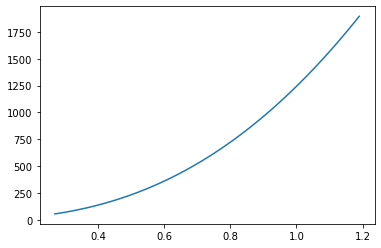

In [109]:
plt.plot(nb_array, sound_speed_diff)

### Okay too big still... so Method 3
$$
    \frac{\partial \sigma}{\partial k_{F_n}} = 
    \frac{\partial \sigma}{\partial k_{F_p}} \frac{\partial k_{F_p}}{\partial k_{F_n}}
    = \frac{\partial \sigma}{\partial k_{F_p}} 
    \left[\frac{\partial k_{F_p}}{\partial n_B}\frac{\partial n_B}{\partial k_{F_n}}\right] 
    = 
    \frac{\partial \sigma}{\partial k_{F_p}} 
    \left[\frac{\pi^2 x_p}{k_{F_p}^2} \frac{k_{F_n}^2}{\pi^2 x_n}\right] 
$$

In [31]:
def partial_fermi_nb(frac, fermi):
    return np.pi**2 * frac / fermi**2

In [32]:
def partial_sigma_kfn_func(part_sig_kfp, neutron_fermi, proton_fermi, neutron_frac, proton_frac):
    return part_sig_kfp * proton_frac * neutron_fermi**2 / proton_fermi**2 / neutron_frac

In [33]:
partial_sigma_kfn_2 = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_sigma_kfn_2[i] = partial_sigma_kfn_func(partial_sigma_kfp[i], fermi_n[i], fermi_p[i], neutron_frac[i], proton_frac[i])

In [34]:
partial_sigma_nb = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    partial_sigma_nb[i] = partial_sigma_kfn_2[i]*np.pi**2 * neutron_frac[i]/fermi_n[i]**2

In [35]:
partial_proton_nb_3 = np.zeros(len(nb_array))
partial_neutron_nb_3 = np.zeros(len(nb_array))

partial_proton_xe_3 = np.zeros(len(nb_array))
partial_neutron_xe_3 = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    partial_proton_nb_3[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp[i], nb_array[i],\
                                        proton_frac[i], 'nb')
    partial_proton_xe_3[i] = partial_chem_pot(Proton, fermi_p[i], sigma_array[i], partial_sigma_kfp[i], nb_array[i],\
                                        proton_frac[i], 'frac')
    
    partial_neutron_nb_3[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn_2[i], nb_array[i],\
                                        neutron_frac[i], 'nb')
    partial_neutron_xe_3[i] = partial_chem_pot(Neutron, fermi_n[i], sigma_array[i], partial_sigma_kfn_2[i], nb_array[i],\
                                        neutron_frac[i], 'frac')

In [36]:
part_mu_tilde_part_nb = partial_neutron_nb - partial_proton_nb 
part_mu_tilde_part_xe = partial_neutron_xe - partial_proton_xe

In [37]:
neutron_chem_pot = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    neutron_chem_pot[i] = eff_energy(Neutron, fermi_n[i], sigma_array[i])

In [38]:
sound_speed_diff = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    sound_speed_diff[i] = (nb_array[i]*n0*hc**3)**2/neutron_chem_pot[i] * part_mu_tilde_part_nb[i]**2 / part_mu_tilde_part_xe[i]

In [39]:
sound_speed_diff

array([-3.80798303e+04, -4.02233257e+04, -4.23870403e+04, -4.45691151e+04,
       -4.67677924e+04, -4.89814061e+04, -5.12083772e+04, -5.34472069e+04,
       -5.56964702e+04, -5.79548120e+04, -6.02209416e+04, -6.24936292e+04,
       -6.47717014e+04, -6.70540381e+04, -6.93395685e+04, -7.16272690e+04,
       -7.39161597e+04, -7.62053023e+04, -7.84937974e+04, -8.07807827e+04,
       -8.30654302e+04, -8.53469457e+04, -8.76245652e+04, -8.98975551e+04,
       -9.21652094e+04, -9.44268485e+04, -9.66818186e+04, -9.89294903e+04,
       -1.01169256e+05, -1.03400531e+05, -1.05622751e+05, -1.07835372e+05,
       -1.10037867e+05, -1.12229732e+05, -1.14410474e+05, -1.16579622e+05,
       -1.18736718e+05, -1.20881321e+05, -1.23013002e+05, -1.25131349e+05,
       -1.27235963e+05, -1.29326456e+05, -1.31402454e+05, -1.33463597e+05,
       -1.35509532e+05, -1.37539920e+05, -1.39554433e+05, -1.41552753e+05,
       -1.43534570e+05, -1.45499587e+05, -1.47447514e+05, -1.49378071e+05,
       -1.51290985e+05, -

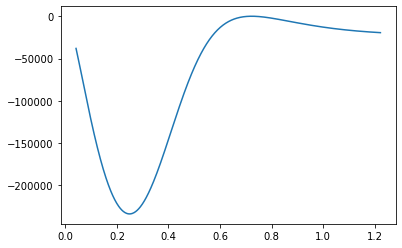

In [40]:
plt.plot(nb_array*n0, sound_speed_diff)

### Still haven't considered meson contribution yet... 